In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import json

In [5]:
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)  
    return pd.DataFrame(data)

df = load_data('/kaggle/input/fast-russian-embeddings/fast_russian_embeddings.json')

In [3]:
df.head()

,filename,label,embedding
0,252099-79.txt,0,"[-0.012139108963310719, 0.02229919657111168, 0..."
1,842673-37.txt,0,"[-0.027081843465566635, 0.023928195238113403, ..."
2,843784-82.txt,0,"[0.01613425277173519, 0.025259848684072495, -0..."
3,521607-8.txt,0,"[-0.03023727424442768, -0.0032445243559777737,..."
4,406175-82.txt,0,"[0.021884415298700333, 0.014899949543178082, 0..."


In [6]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
X = np.array(df['embedding'].tolist())
y = df['label_encoded'].values

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print("Logistic Regression Test Results:")
print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58      2921
           1       0.45      0.15      0.22      3780
           2       0.77      0.94      0.85     13050

    accuracy                           0.73     19751
   macro avg       0.62      0.55      0.55     19751
weighted avg       0.69      0.73      0.69     19751



In [7]:
lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_balanced.fit(X_train, y_train)
print("Balanced Logistic Regression Test Results:")
print(classification_report(y_test, lr_balanced.predict(X_test)))

Balanced Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       0.50      0.72      0.59      2921
           1       0.35      0.49      0.41      3780
           2       0.89      0.70      0.78     13050

    accuracy                           0.66     19751
   macro avg       0.58      0.64      0.59     19751
weighted avg       0.73      0.66      0.68     19751



In [8]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree Test Results:")
print(classification_report(y_test, dt.predict(X_test)))

Decision Tree Test Results:
              precision    recall  f1-score   support

           0       0.30      0.31      0.31      2921
           1       0.23      0.24      0.24      3780
           2       0.73      0.72      0.73     13050

    accuracy                           0.57     19751
   macro avg       0.42      0.43      0.42     19751
weighted avg       0.57      0.57      0.57     19751



In [9]:
dt_balanced = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_balanced.fit(X_train, y_train)
print("Balanced Decision Tree Test Results:")
print(classification_report(y_test, dt_balanced.predict(X_test)))

Balanced Decision Tree Test Results:
              precision    recall  f1-score   support

           0       0.30      0.31      0.30      2921
           1       0.24      0.24      0.24      3780
           2       0.73      0.72      0.73     13050

    accuracy                           0.57     19751
   macro avg       0.42      0.42      0.42     19751
weighted avg       0.57      0.57      0.57     19751



In [8]:
# Modify the code where X is defined
X = np.array(df['embedding'].tolist(), dtype=np.float32)  # Add dtype=np.float32
y = df['label_encoded'].values

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [10]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.layers(x)

In [12]:
input_size = X_train.shape[1]
num_classes = len(le.classes_)
batch_size = 32
epochs = 20
learning_rate = 0.001
model = NeuralNetwork(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    
    val_acc = correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{epochs} | Val Accuracy: {val_acc:.4f}")

Epoch 1/20 | Val Accuracy: 0.7221
Epoch 2/20 | Val Accuracy: 0.7310
Epoch 3/20 | Val Accuracy: 0.7343
Epoch 4/20 | Val Accuracy: 0.7363
Epoch 5/20 | Val Accuracy: 0.7343
Epoch 6/20 | Val Accuracy: 0.7311
Epoch 7/20 | Val Accuracy: 0.7321
Epoch 8/20 | Val Accuracy: 0.7379
Epoch 9/20 | Val Accuracy: 0.7389
Epoch 10/20 | Val Accuracy: 0.7422
Epoch 11/20 | Val Accuracy: 0.7370
Epoch 12/20 | Val Accuracy: 0.7387
Epoch 13/20 | Val Accuracy: 0.7405
Epoch 14/20 | Val Accuracy: 0.7406
Epoch 15/20 | Val Accuracy: 0.7393
Epoch 16/20 | Val Accuracy: 0.7415
Epoch 17/20 | Val Accuracy: 0.7362
Epoch 18/20 | Val Accuracy: 0.7355
Epoch 19/20 | Val Accuracy: 0.7404
Epoch 20/20 | Val Accuracy: 0.7376


In [22]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nNeural Network Test Results:")
print(classification_report(all_labels, all_preds))


Neural Network Test Results:
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      2921
           1       0.44      0.27      0.34      3780
           2       0.80      0.92      0.86     13050

    accuracy                           0.74     19751
   macro avg       0.63      0.58      0.60     19751
weighted avg       0.71      0.74      0.72     19751



In [25]:
class_counts = np.bincount(y_train)
class_weights = 1. / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float32)
criterion_b = nn.CrossEntropyLoss(weight=class_weights)
model_balanced = NeuralNetwork(input_size, num_classes)
optimizer = optim.Adam(model_balanced.parameters(), lr=0.00001)
for epoch in range(epochs):
    model_balanced.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_balanced(inputs)
        loss = criterion_b(outputs, labels)
        loss.backward()
        optimizer.step()
    
    
    model_balanced.eval()
    val_loss = 0
    correct_balanced = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_balanced(inputs)
            val_loss += criterion_b(outputs, labels).item()
            preds_balanced = outputs.argmax(dim=1)
            correct_balanced += (preds_balanced == labels).sum().item()
    
    val_acc = correct_balanced / len(val_dataset)
    print(f"Epoch {epoch+1}/{epochs} | Val Accuracy: {val_acc:.4f}")

Epoch 1/20 | Val Accuracy: 0.6595
Epoch 2/20 | Val Accuracy: 0.6788
Epoch 3/20 | Val Accuracy: 0.6892
Epoch 4/20 | Val Accuracy: 0.6656
Epoch 5/20 | Val Accuracy: 0.6452
Epoch 6/20 | Val Accuracy: 0.6373
Epoch 7/20 | Val Accuracy: 0.6382
Epoch 8/20 | Val Accuracy: 0.6346
Epoch 9/20 | Val Accuracy: 0.6363
Epoch 10/20 | Val Accuracy: 0.6421
Epoch 11/20 | Val Accuracy: 0.6382
Epoch 12/20 | Val Accuracy: 0.6369
Epoch 13/20 | Val Accuracy: 0.6393
Epoch 14/20 | Val Accuracy: 0.6413
Epoch 15/20 | Val Accuracy: 0.6428
Epoch 16/20 | Val Accuracy: 0.6366
Epoch 17/20 | Val Accuracy: 0.6408
Epoch 18/20 | Val Accuracy: 0.6357
Epoch 19/20 | Val Accuracy: 0.6409
Epoch 20/20 | Val Accuracy: 0.6392


In [27]:
model_balanced.eval()
all_preds_balanced = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_balanced(inputs)
        preds_balanced = outputs.argmax(dim=1)
        all_preds_balanced.extend(preds_balanced.numpy())
        all_labels.extend(labels.numpy())

print("\nNeural Network Test Results:")
print(classification_report(all_labels, all_preds_balanced))


Neural Network Test Results:
              precision    recall  f1-score   support

           0       0.44      0.72      0.55      2921
           1       0.28      0.32      0.30      3780
           2       0.87      0.71      0.78     13050

    accuracy                           0.64     19751
   macro avg       0.53      0.58      0.54     19751
weighted avg       0.69      0.64      0.65     19751



In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.hidden_size = hiadden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1) 
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

input_size = X_train.shape[1]
num_classes = len(le.classes_)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size=input_size, 
                 hidden_size=64, 
                 num_layers=1,  
                 output_size=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    
    val_acc = correct / len(val_dataset)
    print(f"Epoch {epoch+1}/{epochs} | Val Accuracy: {val_acc:.4f}")

Epoch 1/10 | Val Accuracy: 0.7402
Epoch 2/10 | Val Accuracy: 0.7403
Epoch 3/10 | Val Accuracy: 0.7411
Epoch 4/10 | Val Accuracy: 0.7378
Epoch 5/10 | Val Accuracy: 0.7423
Epoch 6/10 | Val Accuracy: 0.7395
Epoch 7/10 | Val Accuracy: 0.7370
Epoch 8/10 | Val Accuracy: 0.7418
Epoch 9/10 | Val Accuracy: 0.7424
Epoch 10/10 | Val Accuracy: 0.7433


In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

print("\nNeural Network Test Results:")
print(classification_report(all_labels, all_preds))


Neural Network Test Results:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      2921
           1       0.47      0.22      0.30      3780
           2       0.80      0.93      0.86     13050

    accuracy                           0.74     19751
   macro avg       0.63      0.58      0.59     19751
weighted avg       0.71      0.74      0.72     19751



In [ ]:
import torch
import torch.nn as nn

class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.3):
        super().__init__()
        
        self.hidden_size = hidden_size // 2 * 2 if hidden_size % 2 != 0 else hidden_size
        
        self.num_layers = num_layers
        
       
        self.lstm = nn.LSTM(
            input_size,
            self.hidden_size // 2,  # Split for bidirectional
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )
        
        self.attention = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),  # Fixed input dimension
            nn.Tanh(),
            nn.Linear(self.hidden_size, 1, bias=False)
        )
        
        self.batch_norm = nn.BatchNorm1d(self.hidden_size)
        self.fc_layers = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),  # Fixed input dimension
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(self.hidden_size, output_size)
        )
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):

        x = x.unsqueeze(1)
    
        lstm_out, _ = self.lstm(x)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Batch normalization
        context_vector = self.batch_norm(context_vector)
        
        # Final classification
        out = self.fc_layers(context_vector)
        return out

In [ ]:
input_dim = X_train.shape[1]

model_config = {
    'input_size': input_dim,
    'hidden_size': 128,  
    'num_layers': 2,
    'output_size': len(le.classes_),
    'dropout_prob': 0.4
}


model = EnhancedLSTM(**model_config).to(device)
training_config = {
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'clip_value': 0.5
}

# Initialize optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=training_config['learning_rate'],
    weight_decay=training_config['weight_decay']
)

In [18]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

NameError: name 'compute_class_weight' is not defined

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
import time
import numpy as np

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size,
            hidden_size // 2,  # Split hidden size for bidirectional
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )
        
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_normal_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)

    def forward(self, x):
        x = x.unsqueeze(1)
        
        lstm_out, _ = self.lstm(x)  # (batch_size, 1, hidden_size)
        out = lstm_out[:, -1, :]
        
        out = self.batch_norm(out)
        
        out = self.fc(out)
        return out

def initialize_model(X_train, num_classes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model_config = {
        'input_size': X_train.shape[1],
        'hidden_size': 128,
        'num_layers': 2,
        'output_size': num_classes,
        'dropout_prob': 0.4
    }
    
    model = BidirectionalLSTM(**model_config).to(device)
    
    training_config = {
        'learning_rate': 0.001,
        'weight_decay': 1e-4,
        'clip_value': 0.5
    }
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=training_config['learning_rate'],
        weight_decay=training_config['weight_decay']
    )
    
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    
    return device, model, optimizer, criterion, scheduler

# 3. Training Function
def train_model(model, train_loader, val_loader, optimizer, criterion, device, 
                scheduler=None, epochs=20, clip_value=0.5, patience=3):
    best_val_loss = float('inf')
    no_improve = 0
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        
        # Training
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
    
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)
        
        
        if scheduler:
            scheduler.step(val_loss)
        
    
        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_acc:.4f}')
        print(classification_report(all_labels, all_preds, digits=4))
        print('-' * 60)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

def evaluate_model(model, test_loader, device):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nFinal Test Results:")
    print(classification_report(all_labels, all_preds, digits=4))
    return all_preds, all_labels


if __name__ == "__main__":
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device, model, optimizer, criterion, scheduler = initialize_model(
        X_train=X_train,
        num_classes=len(np.unique(y_train)))
    
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        scheduler=scheduler,
        epochs=20,
        clip_value=0.5,
        patience=3
    )
    
    test_preds, test_labels = evaluate_model(model, test_loader, device)

Epoch 1/20 | Time: 16.74s
Train Loss: 0.6925 | Val Loss: 0.6616
Val Accuracy: 0.7201
              precision    recall  f1-score   support

           0     0.5074    0.7128    0.5928      3012
           1     0.4466    0.1048    0.1697      3713
           2     0.7978    0.8972    0.8446     13025

    accuracy                         0.7201     19750
   macro avg     0.5839    0.5716    0.5357     19750
weighted avg     0.6875    0.7201    0.6793     19750

------------------------------------------------------------
Epoch 2/20 | Time: 16.77s
Train Loss: 0.6511 | Val Loss: 0.6432
Val Accuracy: 0.7289
              precision    recall  f1-score   support

           0     0.6461    0.5169    0.5743      3012
           1     0.4696    0.0978    0.1618      3713
           2     0.7531    0.9579    0.8432     13025

    accuracy                         0.7289     19750
   macro avg     0.6229    0.5242    0.5265     19750
weighted avg     0.6835    0.7289    0.6741     19750

-------

/tmp/ipykernel_31/3690151945.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Final Test Results:
              precision    recall  f1-score   support

           0     0.5924    0.6354    0.6131      2921
           1     0.4731    0.1585    0.2374      3780
           2     0.7930    0.9329    0.8573     13050

    accuracy                         0.7407     19751
   macro avg     0.6195    0.5756    0.5693     19751
weighted avg     0.7021    0.7407    0.7025     19751



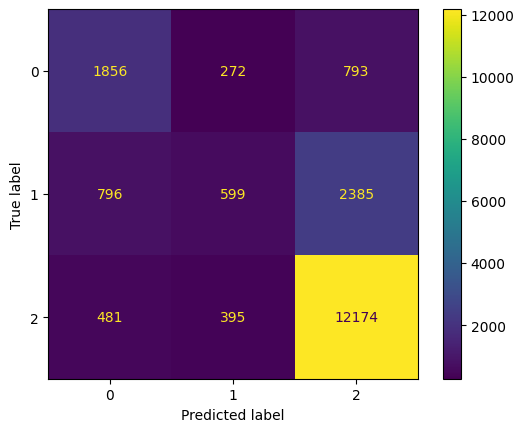

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()